# Gel Printing!
This notebook will help you start printing gel, by calibrating the z offset of your syringe!

In [ ]:
from science_jubilee.Machine import Machine
from science_jubilee.tools.Tool import Tool
from science_jubilee.tools.SyringeExtruder import SyringeExtruder
from science_jubilee.tools.Camera import Camera

In [ ]:
m = Machine(address = "localhost")

The first thing you do is to home the machine, if you need to! Make sure the build plate is clear.

In [ ]:
m.home_all()

Homing could take a minute. Now, define and load tool(s).

In [ ]:
syringe_0 = SyringeExtruder(index = 2, name = "syr1", config = "10cc_syringe")
syringe_1 = SyringeExtruder(index = 3, name = "syr2", config = "10cc_syringe")
m.load_tool(syringe_0) 
m.load_tool(syringe_1)

3D printing fine structures is very sensitive to the z offset (i.e. how close to the bed plate the tip of the nozzle is). The Z offset changes with the nozzle you're using, the length of the syringe, etc. Now we need to zero the nozzle tip and update the z offset.

When printing gel, you can't just take the print off of the bed when it's complete. Instead, we can print on small glass plates. When we calibrate the z offset, we'll want to 

First, pick up the tool you'd like to calibrate.

In [ ]:
# This cell will move the machine!
m.pickup_tool(syringe_0)

The z offset on startup should be slightly higher than the actual z offset, this is to avoid collisions with the bed. You can read more on it on the [Jubilee wiki](https://jubilee3d.com/index.php?title=Setting_Tool_Offsets).
Let's move to the current `Z = 0`.

In [ ]:
# This cell will move the machine!
m.move_to(x=150, y=150)
m.move_to(z = 0)

You'll see that z=0 is actually above the bed! Now we need to bring the tip of the syringe extruder into contact with the print bed by gradually decreasing the z value. You want the tip to be _just_ above the bed plate. Don't overshoot or you'll crash into the syringe!

You can use the control panel in the DuetWebControl interface to do this if you like

In [ ]:
z_offset = -1.5 # slowly make this a bigger negative number, or feel free use the duet web control panel
m.move_to(z = z_offset)

We'll update the tool's z offset so that the 0 position is where you currently moved to. Note that everytime the mainboard restarts, it reads the config on the Duet board, which has the more conservative tool offset. 


Instead of changing the offset permanently, we'll temporarily change it until we restart the machine again. So, we should go through this process each time we add a new syringe tip.

If you want to be able to take your print off the bed, be sure to put a glass plate down and calibrate to the height of the plate!

In [ ]:
starting_offset = m.tool_z_offsets[m.active_tool_index] # this is the default value for this tool
real_z_position = float(m.get_position()["Z"])          # this is our current z position after calibration
new_z_offset = starting_offset - real_z_position        # subtract the two to get the update z offset value

# Update the tool offset
m.set_tool_offset(tool_idx = m.active_tool_index, z = new_z_offset)

In [ ]:
# Our current z position should now be 0!
m.get_position()['Z']

Now you can repeat the process with the second syringe!

In [ ]:
# Pickup your second syringe and move to z=0
m.pickup_tool(syringe_1)
m.move_to(z=0)

In [ ]:
z_offset = -1.5 # slowly make this a bigger negative number, or feel free use the duet web control panel
m.move_to(z = z_offset)

In [ ]:
# update the z offset
starting_offset = m.tool_z_offsets[m.active_tool_index] # this is the default value for this tool
real_z_position = float(m.get_position()["Z"])          # this is our current z position after calibration
new_z_offset = starting_offset - real_z_position        # subtract the two to get the update z offset value

# Update the tool offset
m.set_tool_offset(tool_idx = m.active_tool_index, z = new_z_offset)

In [ ]:
# Our current z position should now be 0!
m.get_position()['Z']

Now we'll try printing a pre-sliced gcode file. Before loading your slicer-generated gcode file, it's a good practice to prime the nozzle - extrude a little bit of material so that the nozzle is filled and ready to print.

Noted that the parameter of `move_extrude` is the length of the filament, i.e. the actual plunger movement. 

In [1]:
# We'll return back to the first syringe to try printing something!
m.pickup_tool(syringe_0)

In [ ]:
m.move_to(z = 25) # move the bed away if it's too close to the nozzle so that you can more easily clean ooze
syringe_0.move_extrude(e=1) # you may need to re-run this cell several times, until the syringe starts oozing!

These are some helper functions to load gcode and print gcode:

In [ ]:
# These functions will let us print a pre-sliced cylinder model
# nothing will happen when your run this cell
def load_gcode(file_path):
    try:
        lines = []
        with open(file_path, 'r') as file:
            for line in file:
                lines.append(line.strip())
        return lines
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def print_gcode(gcode):
    for line in gcode:
        if len(line) > 0:
            if not line.startswith(';'):
                print(line)
                m.gcode(line)

Now try printing! When we start the print, the machine will first home the z axis to level the bed, and then it will start printing. 

_If you're using a glass plate, you should remove the plate while the machine is homing, and the put it back in place when the print starts!_ 

In [ ]:
# Once you run this cell, the machine will start printing a small cylinder!
# First it will park all tools and home the z axis
# and then it will pick up the syringe and start printing
# Position your glass plate in the center of after the machine is done homing if using
# press the 'Stop' button in the top toolbar to stop the print
gcode = load_gcode("cylinder-20mm.gcode")
print_gcode(gcode)

You might notice that it doesn't look great on your machine! This example was sliced with a bunch of default parameters like speed and extrusion. To tune your print, you may want to slice your own model and tune different settings; take a look at the README.md file for more information.

In [ ]:
m.park_tool()

## Other 3D Printing Options!
With the syringe extruder tool, we can also directly specify simple toolpaths to print; this might be useful if you want to directly extrude in a particular location, or do other things of that nature

Note that this functionality is quite basic, especially compared to built-in slicer features!

### Test cube
Here we'll print this test cube with a raised side:

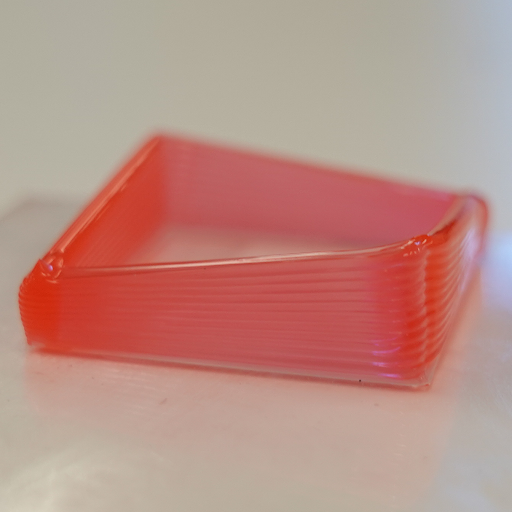

In [ ]:
# Pick up your syringe
m.pickup_tool(syringe_0)

In [ ]:
# Set up some printing parameters
# Change these if and as you'd like!
z = 0              # starting z value
layer_height = 0.2 
z_off = 0          # how much to offset one corner

# put your glass plate at the center of the bed if using
start_x = 150      # x start position
start_y = 150      # y start position
side_length = 20   # side length of the cube

m.move_to(x=start_x, y=start_y, z=z)


# the move_extrude command will extrude gel from the current position to the specified position
# you can edit the extrusion multiplier if you'd like more/less gel extruded, or specify a speed to move at
for layer in range(40):
    syringe_0.move_extrude(x = start_x + side_length, y = start_y, z = z, multiplier = 1)
    syringe_0.move_extrude(x = start_x + side_length, y = start_y - side_length, z = z + z_off, multiplier = 1)
    syringe_0.move_extrude(x = start_x, y = start_y - side_length, z = z + z_off, multiplier = 1)
    syringe_0.move_extrude(x = start_x, y =start_y, z = z, multiplier = 1)
    z += layer_height
    z_off += 0.1

If you've tried both of these examples, now you might come up with some other idea you want to try! If you want to do printing with two syringes, check out the README.md file on how to set that up. That will involve using PrusaSlicer; we have some laptops set up to use if you'd like, and we can help out with editing settings! 